# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [221]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Count the numbers of labels
unique = []
[unique.append(x) for x in y_train if not x in unique]
print(len(unique))
print(max(X_train[3,15,:,2]))

43
229


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [222]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(unique)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

The total probability of ytrain_label is 1.0, and the size of ytrain_distribution is 43.


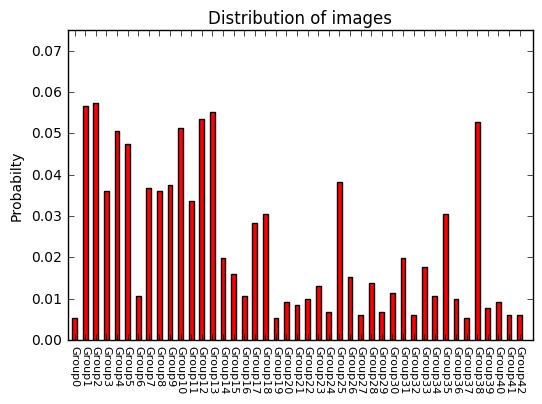

In [223]:
### Data Visualization Part
### I follow my reviewer's suggestion and decide plot the distribution images
import matplotlib.pyplot as plt
import numpy as np
y_train_list = list(y_train)
ytrain_label_distribution = []
for i in range(n_classes):
    ytrain_label_distribution.append(y_train_list.count(i)/n_train)
print('The total probability of ytrain_label is {}, and the size of ytrain_distribution is {}.'.format(sum(ytrain_label_distribution),len(ytrain_label_distribution)))

### plot the distribution of data
fig = plt.figure()
ax = fig.add_subplot(111)
ind = np.arange(n_classes)
width = 0.45
rects1 = ax.bar(ind,ytrain_label_distribution,width,color = 'red')
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,0.075)
ax.set_ylabel('Probabilty')
ax.set_title('Distribution of images')
ax.set_xticks(ind+width/2)
xTickMarks = ['Group'+str(i) for i in range(n_classes)]
xTickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xTickNames,rotation = -90, fontsize = 8)
plt.show()


The distribution above showed that some type of traffic sign samples are significantly less than others. To improve the network's robustness, I assume increasing the sizes of the samples of the types of traffics with small distributions will help.

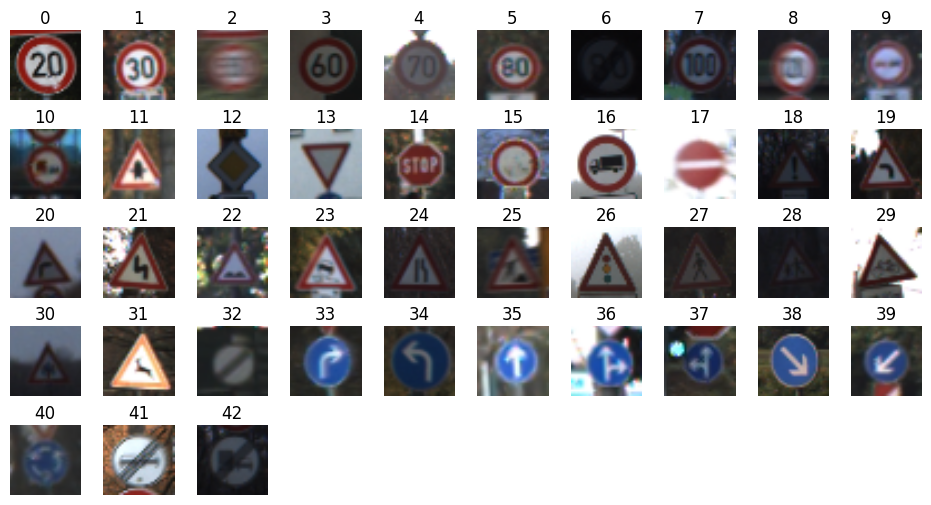

In [224]:
### Draw 43 images, randomly select one image from each class
fig, axes = plt.subplots(5, 10, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.4, wspace=0.05)
import random
def find_all_index(arr,item):
    return [i for i,a in enumerate(arr) if a==item]

for i,ax in enumerate(axes.flat):
    if i< 43:
        indexs = find_all_index(list(y_train),i)
        index = random.randint(0,len(indexs))
        index = indexs[index]
        sampleimage = X_train[index]
    
        ax.imshow(sampleimage)
        ax.axis('off')
        ax.set_title(str(i))
    else:
        fig.delaxes(ax)
        
plt.show()    

The above images of traffic signs showed that some traffic signs are too dark to see and some are very blurry to tell whatever's going on. So I assumme adjusting the brightness and contrast would help. I will do an adaptive histogram equalization on these images.

In [225]:
import cv2
for img in X_train:
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img[:,:,1] = cv2.equalizeHist(img[:,:,1])
    img[:,:,2] = cv2.equalizeHist(img[:,:,2])
print("Histogram Equalization done")
print("The size is",X_train.shape)

Histogram Equalization done
The size is (39209, 32, 32, 3)


Plot 43 random pics with brighness spread out:

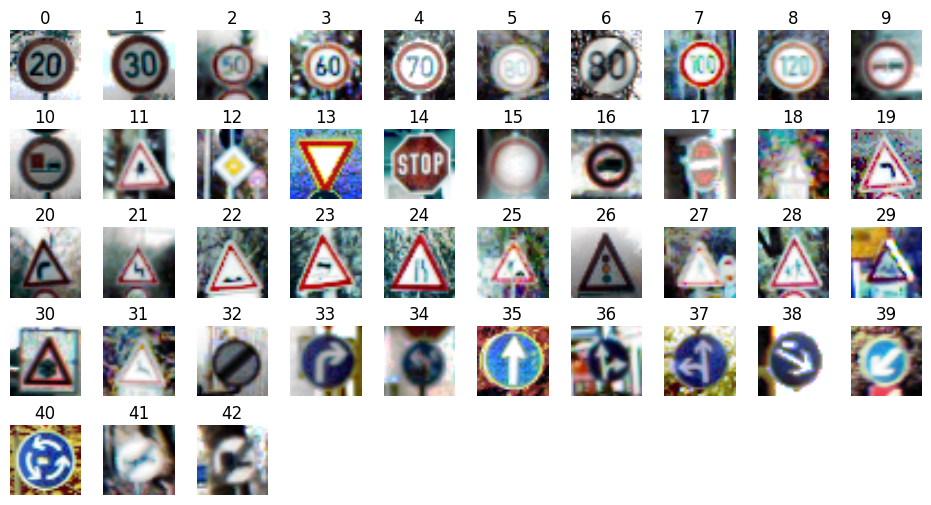

In [226]:
### Draw 43 images, randomly select one image from each class
fig, axes = plt.subplots(5, 10, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.4, wspace=0.05)
for i,ax in enumerate(axes.flat):
    if i< 43:
        indexs = find_all_index(list(y_train),i)
        index = random.randint(0,len(indexs))
        index = indexs[index]
        sampleimage = X_train[index]
        #print(i,'class brightness','=',sampleimage.mean())
        ax.imshow(sampleimage)
        ax.axis('off')
        ax.set_title(str(i))
    else:
        fig.delaxes(ax)
        
plt.show()    

These images now have better contrast and are easier to tell compared to before. 

0


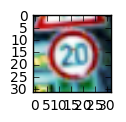

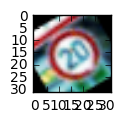

In [227]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
import cv2
image10 = X_train[9].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image10)
print(y_train[9])
plt.show()
# I want to see how it looks after rotation
num_rows,num_cols = X_train[9].shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((num_rows/2,num_cols/2),30,1)
img_rotation = cv2.warpAffine(X_train[9],rotation_matrix,(num_rows,num_cols))
plt.figure(figsize=(1,1))
plt.imshow(img_rotation)
plt.show()
# Visualizations will be shown in the notebook.
%matplotlib inline

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [228]:
def normalize_grayscale(image_data):
    a = -0.5
    b = 0.5
    x_min = 0
    x_max = 255
    return a+(image_data-x_min)*(b-a)/(x_max-x_min)

I put the data visualization part on top. I will add some rotational images to help train the model.

In [229]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random

# Shuffle the data
X_train, y_train = shuffle(X_train,y_train)

# Split the training data into training data and validation data
# the validation data is about 20% of the original data
X_train, valid_features, y_train, valid_labels = train_test_split(
    X_train,
    y_train,
    test_size=0.2)

# Generate some new data, rotation variants
num_rows,num_cols = X_train[0].shape[:2]
X_train_rotations=[]
for i in range(int(len(X_train)/2)):
    degree = random.randint(-15, 15)
    rotation_matrix = cv2.getRotationMatrix2D((num_rows/2,num_cols/2),degree,1)
    img_rotation = cv2.warpAffine(X_train[i],rotation_matrix,(num_rows,num_cols))
    X_train_rotations.append(img_rotation)
print('rotation complete!')


rotation complete!


1


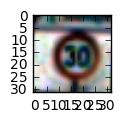

In [230]:
#draw a sample to see how it looks
pic_index = random.randint(0,int(len(X_train)/2))
image_test = X_train_rotations[pic_index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image_test)
print(y_train[pic_index])
plt.show()


In [231]:
# add new created data to the training set

X_train = np.append(X_train,X_train_rotations,axis=0)
y_train = np.append(y_train,y_train[:len(X_train_rotations)])

# Shuffle the data
X_train, y_train = shuffle(X_train,y_train)

In [232]:
# Normalize the features to center the pixels
X_train = normalize_grayscale(X_train)
valid_features = normalize_grayscale(valid_features)
# histogram equalization on the test set as well
for img in X_test:
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img[:,:,1] = cv2.equalizeHist(img[:,:,1])
    img[:,:,2] = cv2.equalizeHist(img[:,:,2])
print("Histogram Equalization on X_test done")
X_test = normalize_grayscale(X_test)

Histogram Equalization on X_test done


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** 
1. Some images were either very dark or very bright and the contrast was low. So I used a technique called histograms equalization to increase the contrast and have the light intensity better distributed across the histogram.
2. By looking at the distribution of the graph, I see that some classes of data have very low distribution. For simplicity I just created another training set with images rotated and added to the original set (Maybe I should make each class distribution even, but that seems complex so I'm just goning to skip it).
3. I also shuffled the data so it is more uniform.
4. I added normalization before training the data in the neural network, hopefully this improve the efficiency of the algorithm by centering pixels around zero.

In [233]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
1. I used the sklearn.model_selection tool to set up the training and validation data. I split the original training data into 80 percent new training data and 20 percent validation data.
2. I added a new data called the X_train_rotations. I generated the data by applying the rotational transform to the new training data via two opencv function called 'getRotationMatrix2D' and 'warpAffine'. The degree they rotate is randomized ranging from -15 to 15 degree.
3. The reason I generated this piece of data is because some distribution of the types of traffics signs are very low, so I added these rotational ones as supplement. 
4. The new dataset(haven't include the generated data yet, I don't think my machine can handle it) would see changes in terms of rotations and missing pixels(due to rotation).

In [234]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten
# This is just taken from the LeNet lab
def LeNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,6,16),mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1,conv2_W,strides=[1,1,1,1],padding='VALID')+conv2_b

    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
        
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    # Add a dropout hidden layer
    #fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2   = tf.matmul(fc1, fc2_W) + fc2_b
    
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    # Add a dropout hidden layer
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits   = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits    



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
The architecture is based on the LeNet-5. I changed only some of parameters of the original network.
So for the first layer, it is a convolutional layer with input size (32,32,3) and output size (28,28,6). To find a filter size for it I followed the equation that was provided in class: new_height = (input_height - filter_height + 2 * P)/S + 1. Since the output size isn't half of the original input size, so the stride S term is set to 1. Since I don't care about the edges of the image, so I choose a 'VALID' padding algorithm to do so. Since it is 'VALID' padding, this means the P term goes to zero. So the filter size can be easily calculated by just plugging the input size and output size value. 

Follow by the convolutional layer is a hidden layer called the activation layer, it basically gets rid of the negative weight terms. I choose it to be RELU activation because it's the easiest one to understand.

After activatio layer comes the max_pooling layer, this layer reduces unsignificant features and helps to prevent over-fitting. The size of the max_pooling filter is 2 by 2, so it compares 4 pixesl adjacent to each other and pick the largest one. The stride is 2 by 2 so it shrinks to output to half. There are no particular reason why I choose max_pooling instead of other pooling method. This was given in LeNet5 so I used it.

Layer 2 is pretty much the same as layer except at the last stage it flatten the 2D array into 1D array so it could connect it self to a fully connected layer network. 

Layer 3 is a fully connected layer, it has a activation layer as well.

Layer 4 is a fully connected layer as well, I've added a drop-out hidden layer to make the architecture be skeptical about outcomes. One can specify the keep probability here.

Layer 5 is the last fully connected layer, I changed output size to be 43 since we have 43 outcomes. 

The architecture will generate a score based on the weights and biases choosen. Then this score will be turned into probabilities with softmax function. Next the system will evaluate the loss by taking the cross-entropy of the softmax result and the one_hot_encoded label. Finally the system train the model by minizming the loss through a gradient decent based rule. Here for this architecture I choose the AdamOptimizer rule. I heard it performance like the stochastic gradient decent rule but better. 

In [235]:
### Train your model here.
### Feel free to use as many code cells as needed.
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

rate = 0.001
EPOCHS = 15
BATCH_SIZE = 64

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [236]:
# The evaluation part
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, keep_prob:1.0, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [237]:
# The training part
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, keep_prob:0.5, y: batch_y})
            
        validation_accuracy = evaluate(valid_features,valid_labels)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet_traffic.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.882

EPOCH 2 ...
Validation Accuracy = 0.954

EPOCH 3 ...
Validation Accuracy = 0.965

EPOCH 4 ...
Validation Accuracy = 0.975

EPOCH 5 ...
Validation Accuracy = 0.976

EPOCH 6 ...
Validation Accuracy = 0.980

EPOCH 7 ...
Validation Accuracy = 0.980

EPOCH 8 ...
Validation Accuracy = 0.979

EPOCH 9 ...
Validation Accuracy = 0.983

EPOCH 10 ...
Validation Accuracy = 0.984

EPOCH 11 ...
Validation Accuracy = 0.985

EPOCH 12 ...
Validation Accuracy = 0.986

EPOCH 13 ...
Validation Accuracy = 0.986

EPOCH 14 ...
Validation Accuracy = 0.985

EPOCH 15 ...
Validation Accuracy = 0.987

Model saved


In [238]:
with tf.Session() as sess:
    saver.restore(sess, './lenet_traffic.ckpt')

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.944


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I used the optimizer from LeNet-Lab, which is the AdamOptimizer. I set the batch size to be 64, epochs to be 15, the dropout probability to be 50% at the train stage and 0% at the validation stage. The learning rate is set to 0.001

There are other approaches for solving this problem. I read from the website that you can use KNN to classify images as well. However KNN is expensive to apply, altough it takes no time to train. Convet is the vice versa of KNN, so it is more applicaple in real life.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
1. I first tried the default LeNet-Lab solution to classify the traffic signs.

2. After experiment I wanted to improve the result so I decided to add an extra set of training data(the rotational ones) to the original training data.

3. I then modified the network to have two hidden layers of dropout layer, that didn't do so well and I think the reason is because the system is too skeptical about the outcomes. So I changed back to only one layer.

4. Then I ran the network again and accurary tops at 93%.

5. Next I tried to increase the batch size to be 256 to if will do better. It actucally did worse than before so I shrinked the batch size to be 64. Now it does better.

6. I added 5 more iterations to train the network, making the epochs to be 15. The accuracy tops at 96%.

7. I went back to check for the code and found out that I didn't normalize the input features, so I added the normalization part.

8. After I read the review I preprocessed my image data with histogram equalization.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Histogram Equalization on new test images done
the new test image set is of size(7, 32, 32, 3)


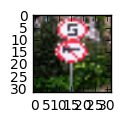

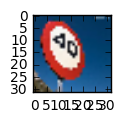

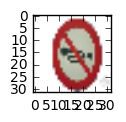

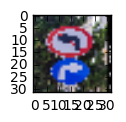

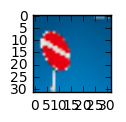

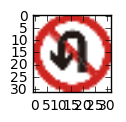

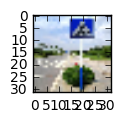

In [239]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import os
list_imgs = os.listdir("online_trafficsigns/")
new_testimgs = []
k=0
for item in list_imgs:    
    image = mpimg.imread('online_trafficsigns/'+item)
    image = cv2.resize(image,(32,32))
    new_testimgs.append(image)
    plt.figure(figsize=(1,1))
    plt.imshow(new_testimgs[k]) #plot the picture to what happens
    k=k+1
# print new_testimgs size
new_testimgs = np.array(new_testimgs)
# apply histogram equalization
for img in new_testimgs:
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img[:,:,1] = cv2.equalizeHist(img[:,:,1])
    img[:,:,2] = cv2.equalizeHist(img[:,:,2])
print("Histogram Equalization on new test images done")

new_testimgs = normalize_grayscale(new_testimgs)
labels = np.array([18,18,18,33,17,18,27])
print('the new test image set is of size{}'.format(new_testimgs.shape))    

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I set up seven images for this task, all of them are from the internet. There are two images with two signs, this is difficult even for a human to recognize it. Also these images have been resized, so some of the features got distorted or lost. Some of the images doesn't have a label, like the 'No U-turn' or 'No-Horn' ones, so it would be difficult for machine to recognize them. Another thing to notice is that these pictures are shot from different distance and angle, so they aren't formated as well as the one provided in the training set.


In [240]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, './lenet_traffic.ckpt')

    test_accuracy_2 = evaluate(new_testimgs, labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy_2))


Test Accuracy = 0.143


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
I've got one of them correct. 

In [248]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
mysoftmax = tf.nn.softmax(logits)
myprediction = tf.nn.top_k(mysoftmax,k=5)
mylist = []
with tf.Session() as sess:
    saver.restore(sess, './lenet_traffic.ckpt')
    sess = tf.get_default_session()
    result_test = sess.run(myprediction,feed_dict={x:new_testimgs,keep_prob:1.0})
    #print(result_test)
    mylist.append(result_test)

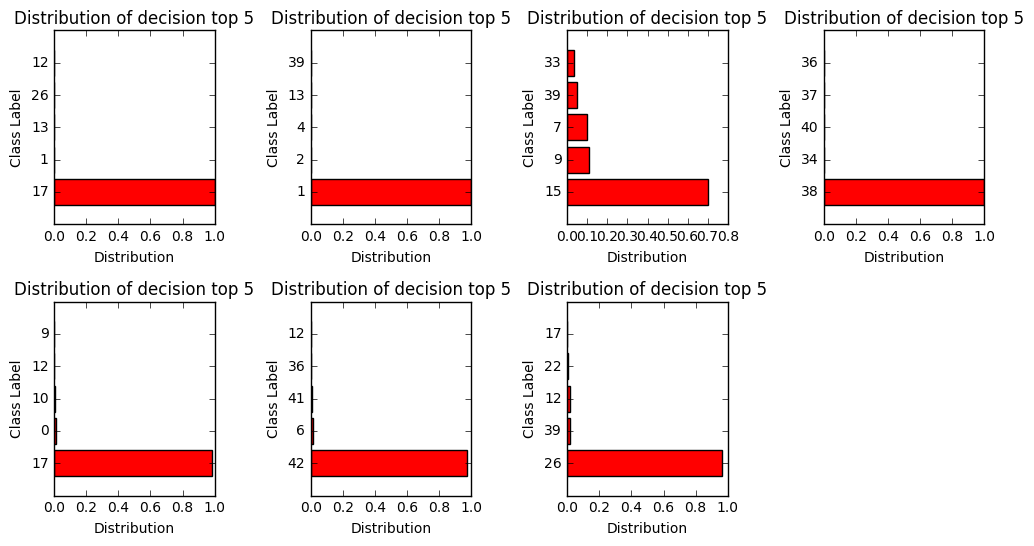

In [263]:
result_label = mylist[0][1]
result_distribution = mylist[0][0]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4,wspace=0.6)
y_pos = np.arange(5)
for i,ax in enumerate(axes.flat):
    if i<7:
        ax.barh(y_pos,result_distribution[i],align='center',color='red')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(result_label[i])
        ax.set_xlabel('Distribution')
        ax.set_ylabel('Class Label')
        ax.set_title("Distribution of decision top 5")
    else:
        fig.delaxes(ax)
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
I got one out of seven correct. I was only expecting the no-entry sign and the pedestrian sign to be correct since they are the only signs with the proper label inside the csv file. I got the no-entry sign correct but not the pedestrian sign. But I think it's okay that it didn't get it correct since the sign was so small and difficult to see even for human. And I checked the bar graph, no the second biggest probability didn't show up as well. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.